Objective- Forecast fog images

In [ ]:
!wget https://fog.iitk.ac.in/fog-prediction/prashad/sample_fog_prob.rar

--2024-07-02 16:10:04--  https://fog.iitk.ac.in/fog-prediction/prashad/sample_fog_prob.rar
Resolving fog.iitk.ac.in (fog.iitk.ac.in)... 202.3.77.30
Connecting to fog.iitk.ac.in (fog.iitk.ac.in)|202.3.77.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49503363 (47M) [application/rar]
Saving to: ‘sample_fog_prob.rar.9’

sample_fog_prob.rar 100%[===================>]  47.21M  2.27MB/s    in 11s     

2024-07-02 16:10:15 (4.47 MB/s) - ‘sample_fog_prob.rar.9’ saved [49503363/49503363]



In [ ]:
!wget https://fog.iitk.ac.in/fog-prediction/prashad/BNN/roi_bool_arr.npy

--2024-07-02 16:10:15--  https://fog.iitk.ac.in/fog-prediction/prashad/BNN/roi_bool_arr.npy
Resolving fog.iitk.ac.in (fog.iitk.ac.in)... 202.3.77.30
Connecting to fog.iitk.ac.in (fog.iitk.ac.in)|202.3.77.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2614816 (2.5M)
Saving to: ‘roi_bool_arr.npy.9’

roi_bool_arr.npy.9  100%[===================>]   2.49M  2.91MB/s    in 0.9s    

2024-07-02 16:10:17 (2.91 MB/s) - ‘roi_bool_arr.npy.9’ saved [2614816/2614816]



In [ ]:
!pip install rarfile

In [ ]:
import rarfile

def extract_ra(file_path, extract_path):
    with rarfile.RarFile(file_path, 'r') as rf:
        rf.extractall(extract_path)

# Example usage
file_path = '/content/sample_fog_prob.rar'
extract_path = '/content/'
extract_ra(file_path, extract_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Do not use files ending with _alea, _epi

In [ ]:
img_arr = np.load('/content/sample_fog_prob/03DEC2023_1200.npy')
print(img_arr.shape)

(121925,)


The values in tha array indicate probability, and thus take values between 0 and 1

(array([   351.,    554.,    786.,    876.,   1087.,   1439.,   1939.,
          3074.,   6431., 105388.]),
 array([0.00139036, 0.08994148, 0.17849261, 0.26704371, 0.35559484,
        0.44414595, 0.53269708, 0.62124819, 0.70979929, 0.79835045,
        0.88690156]),
 <BarContainer object of 10 artists>)

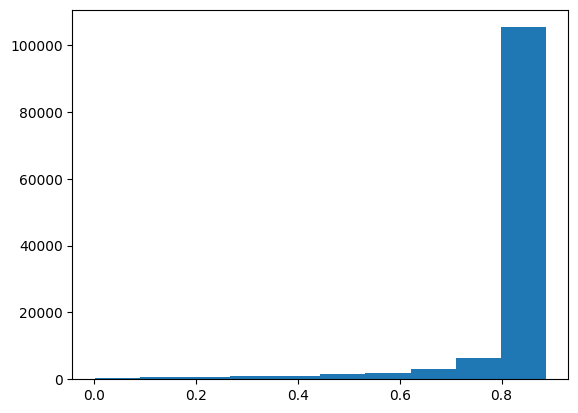

In [ ]:
plt.hist(img_arr)

(350, 650)


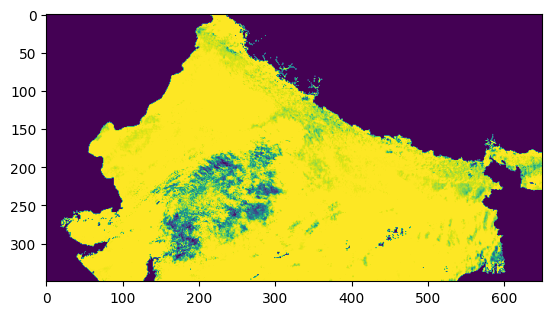

In [ ]:
#Code added by Prasad to convert 1D array into 2D array

def convert_2D(img_arr):
    bool_array = np.load('/content/roi_bool_arr.npy')
    #Below are the row col numbers for small image
    start_row, end_row = 400, 750
    start_col, end_col = 600, 1250
    temp=np.zeros((1616,1618))
    x=img_arr
    temp[bool_array] = x
    # print('temp',temp.shape)
    # print('temp val', np.max(temp.flatten()), np.min(temp.flatten()))
    # plt.imshow(temp)
    # plt.show()
    small_img = temp[start_row:end_row, start_col:end_col]
    # plt.imshow(small_img)
    # plt.show()
    return small_img

img_2D_arr = convert_2D(img_arr)
plt.imshow(img_2D_arr)
print(img_2D_arr.shape)

For half hour and one hour lead time, predict next images.
Things to keep in mind -
1. There can be missing values, they should be handled (maybe by interpolation)
2. Evaulation metircs? (RMSE)

Shape of roi_bool_arr: (1616, 1618)
Shape of img_arr_roi: (1616, 1618)


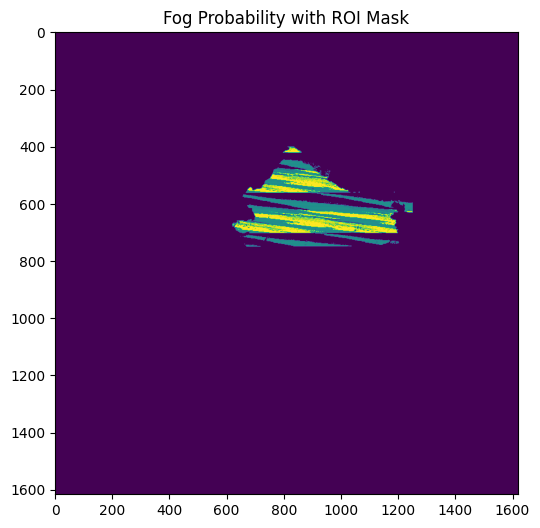

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to handle missing values using linear interpolation
def handle_missing_values(arr):
    nans = np.isnan(arr)
    x = lambda z: z.nonzero()[0]
    arr[nans] = np.interp(x(nans), x(~nans), arr[~nans])
    return arr

# Load ROI boolean array
roi_bool_arr = np.load('/content/roi_bool_arr.npy')
print(f"Shape of roi_bool_arr: {roi_bool_arr.shape}")

# Example to load and handle missing values in a fog probability array
img_arr = np.load('/content/sample_fog_prob/03DEC2023_1200.npy')

# Handle missing values in fog probability array using interpolation
img_arr = handle_missing_values(img_arr)

# Reshape img_arr to match the shape of roi_bool_arr
img_2D_arr = convert_2D(img_arr)  # Assuming convert_2D function is defined correctly

# Ensure img_2D_arr has the same shape as roi_bool_arr
if img_2D_arr.shape != roi_bool_arr.shape:
    img_2D_arr = np.resize(img_2D_arr, roi_bool_arr.shape)

# Apply ROI mask to the fog probability data
img_arr_roi = img_2D_arr * roi_bool_arr

# Check the shape of img_arr_roi
print("Shape of img_arr_roi:", img_arr_roi.shape)

# Visualize the fog probability image after interpolation and masking
plt.figure(figsize=(8, 6))
plt.imshow(img_arr_roi, cmap='viridis')
plt.title('Fog Probability with ROI Mask')
plt.show()



In [ ]:
import os
from sklearn.model_selection import train_test_split

# Load all the fog probability images into a list
file_list = sorted(os.listdir('/content/sample_fog_prob'))
data = []

for file_name in file_list:
    if file_name.endswith('.npy'):
        img_arr = np.load(os.path.join('/content/sample_fog_prob', file_name))
        img_arr = handle_missing_values(img_arr)
        img_2D_arr = convert_2D(img_arr)
        data.append(img_2D_arr)

data = np.array(data)
print(f'Data shape: {data.shape}')

# Split the data into training and testing sets
X = data[:, np.newaxis, :, :, np.newaxis]  # Add dummy dimensions for ConvLSTM2D
y = data  # Assuming the output is the same as input for autoencoder-like training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')



Data shape: (179, 350, 650)
Training data shape: (143, 1, 350, 650, 1)
Testing data shape: (36, 1, 350, 650, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 350, 650,    38144     
                             32)                                 
                                                                 
 batch_normalization (Batch  (None, None, 350, 650,    128       
 Normalization)              32)                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 350, 650, 32)      73856     
                                                                 
 batch_normalization_1 (Bat  (None, 350, 650, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d (Conv2D)             (None, 350, 650, 1)       289       
                                                        

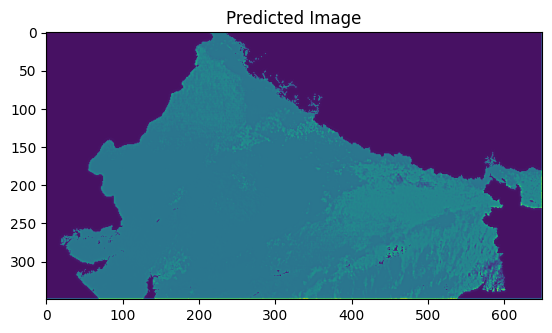

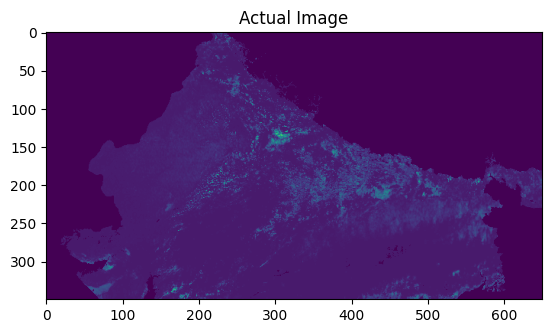

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are already defined and correctly shaped

# Define the ConvLSTM2D model
model = Sequential([
    ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(None, X_train.shape[2], X_train.shape[3], 1),
               padding='same', return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False),
    BatchNormalization(),
    Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='mse')
# Print model summary
model.summary()

model.fit(X_train, y_train, epochs=10, batch_size=2, validation_split=0.1)

# Predict future images for 1 hour lead time
y_pred = model.predict(X_test, batch_size=1)

# Flatten the arrays for RMSE calculation
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
print(f'RMSE: {rmse}')
# Calculate accuracy (as 1 - RMSE)
accuracy = 1 - rmse
print(f'Accuracy: {accuracy}')
# Visualize the predicted image
plt.imshow(y_pred[0, :, :, 0], cmap='viridis')  # Assuming y_pred has shape (batch_size, height, width, channels)
plt.title('Predicted Image')
plt.show()
#Visulaise actual image
plt.title('Actual Image')
plt.imshow(img_2D_arr)







36/36 [==============================] - 1s 8ms/step
RMSE: 0.28507807103875477
Accuracy: 0.7149219289612452


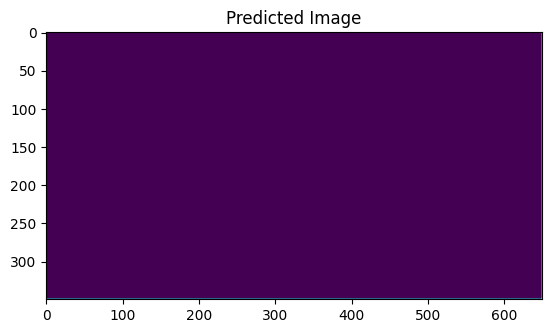

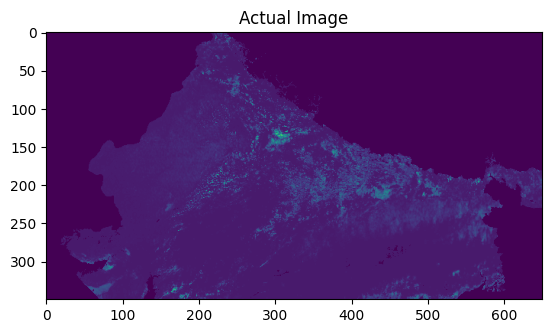

In [ ]:
# Predict for half-hour lead time
y_pred_half_hour = model.predict(X_test[:, :-1], batch_size=1)
# Flatten the arrays for RMSE calculation
y1_pred_flat = y_pred_half_hour.flatten()
y_test_flat = y_test.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_flat, y1_pred_flat))
print(f'RMSE: {rmse}')
# Calculate accuracy (as 1 - RMSE)
accuracy = 1 - rmse
print(f'Accuracy: {accuracy}')
# Visualize the predicted image
plt.imshow(y_pred_half_hour[0, :, :, 0], cmap='viridis')  # Assuming y_pred has shape (batch_size, height, width, channels)
plt.title('Predicted Image')
plt.show()
#Visulaise actual image
plt.title('Actual Image')
plt.imshow(img_2D_arr)
